# Performance Evaluation

In [40]:
from datetime import timedelta
from typing import NamedTuple
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams['figure.figsize'] = (12, 8)
#plt.rcParams["figure.autolayout"] = True

def load_store(path: str):
    with pd.HDFStore(path) as store:
        return store['results'] if 'results' in store else None

lowStore_times = load_store('../DoublyLinkedLowStore_times.h5')
lowStore_memory = load_store('../DoublyLinkedLowStore_memory.h5')

highStore_times = load_store('../DoublyLinkedHighStore_times.h5')
highStore_memory = load_store('../DoublyLinkedHighStore_memory.h5')

humanTaskNames = {
    "infer": "infer-task",
    "sparql": "sparql-task",
    "buildkb": "buildkb-task",
    "shacl": "shacl-task"
}

taskColors = {
    "infer": "#0083CC",
    "sparql": "#F5A300",
    "buildkb": "#009D81",
    "shacl": "#C9308E"
}

taskOrder = {
    "buildkb": 0,
    "sparql": 1,
    "shacl": 2,
    "infer": 3,
}

def flatten_for_metric(store, metric):
    list_entries = store[[metric]].applymap(
        lambda x: list(map(lambda z: z[1], sorted([(k, x[k]) for k in x], key=lambda y: taskOrder[y[0]]))))
    columns = sorted(store.iloc[0][metric].keys(), key=lambda x: taskOrder[x])

    return pd.DataFrame(
        [x for [x] in list_entries.to_numpy()],
        columns=columns,
        index=list_entries.index
    )

primitives = (int, float)

def save_csv(store, metric, index_label, file):
    flattened = flatten_for_metric(store, metric)

    def to_float(x):
        if type(x) in primitives:
            return x / (1024 * 1024)
        elif x.total_seconds is not None:
            return x.total_seconds()
        else:
            raise 'unknown type'
            

    transformed = flattened.applymap(to_float)
    transformed.rename(columns=humanTaskNames, inplace=True)
    transformed.to_csv(file, index_label=index_label)

def plotTaskComparison(
        store,
        metric,
        frameTransform,
        labelMaker,
        ymax: Optional[float],
        ymin: Optional[float],
        xlabel: Optional[str],
        ylabel: Optional[str],
        fileBaseName: Optional[str]
):
    tasks = store[metric].iloc[0].keys()
    tasks = [task for task in tasks if task in humanTaskNames]
    tasks.sort(key=lambda x: taskOrder.get(x, max(taskOrder.values()) + 1))
    labels = store.index

    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots()

    idx = 0
    for task in tasks:
        frame = frameTransform(store[metric].transform(lambda x: x[task]))
        subfig = ax.bar((x + (idx * width / len(tasks))) - width / 2 + width / len(tasks) / 2, frame,
                        width=width / len(tasks), label=task, color=taskColors[task])
        ax.bar_label(subfig, labels=labelMaker(frame), padding=3)
        #fig.set_yscale('symlog')
        idx = idx + 1

    plt.legend([humanTaskNames[task] for task in tasks])
    ax.set_xticks(x, labels)
    
    oldmin, oldmax = ax.get_ylim()
    if ymax:
        ax.set_ylim([oldmin, ymax])
    if ymin:
        ax.set_ylim([ymin, oldmax])

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    fig.tight_layout()
    plt.show()

    if fileBaseName is not None:
        fig.savefig(f"{fileBaseName}.pdf", bbox_inches='tight')


def plotTaskTimeComparison(store, ymin, ymax, fileBaseName: Optional[str], showMilliseconds=False):
    xlabel = "nodes"
    save_csv(store, 'times', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'times',
        lambda frame: frame.astype('timedelta64[ns]').transform(lambda x: x / timedelta(seconds=1) if not showMilliseconds else x / timedelta(milliseconds=1)),
        lambda frame: ["{:.2f}ms".format(f) if showMilliseconds else "{:.2f}s".format(f) for f in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="time [ms]" if showMilliseconds else "time [s]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )


def plotTaskMemoryComparison(store, ymin, ymax, fileBaseName: Optional[str]):
    xlabel = "nodes"
    save_csv(store, 'memory', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'memory',
        lambda frame: frame.transform(lambda x: x / (1024 * 1024)),
        lambda frame: ["{:.0f}MiB".format(v) for v in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="peak memory usage [MiB]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )

# Low Store

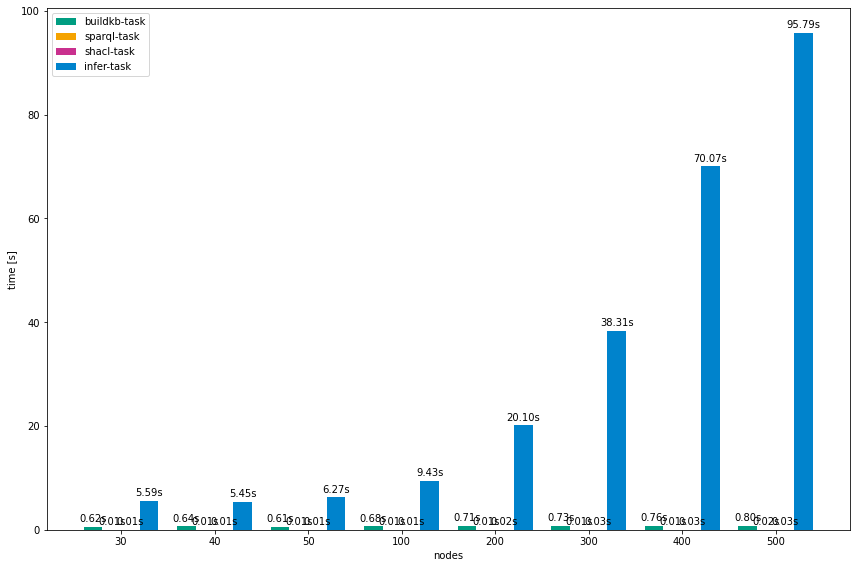

In [10]:
plotTaskTimeComparison(lowStore_times, ymin=None, ymax=None, fileBaseName="doublylinked_low_times")

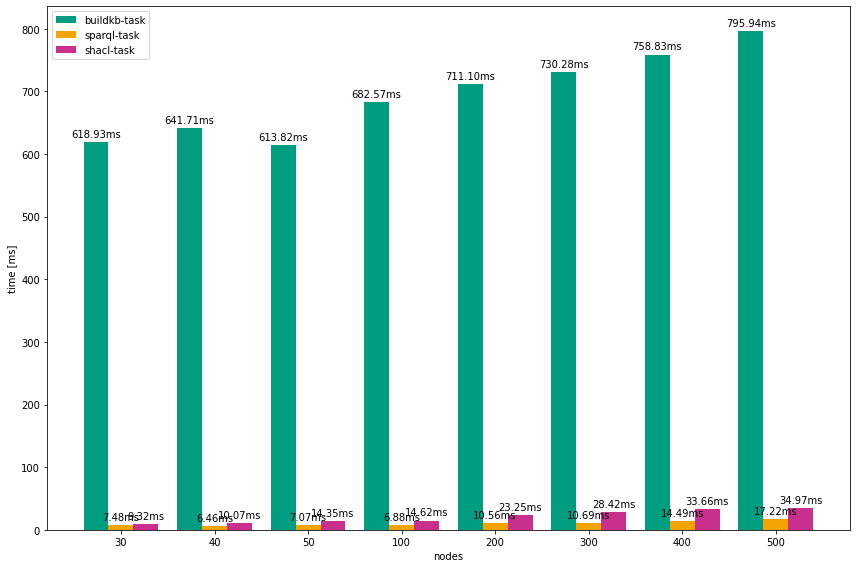

In [49]:
noInferStore = lowStore_times.copy()
noInferStore['times'] = noInferStore['times'].apply(lambda x: {k: x[k] for k in x if k != 'infer'})
plotTaskTimeComparison(noInferStore, ymin=None, ymax=None, fileBaseName="doublylinked_low_times_detail", showMilliseconds=True)

In [51]:
frame = pd.DataFrame(
    lowStore_times['times'].transform(lambda x: pd.Series(map(lambda v: v.total_seconds()*1000, x.values()))),
)
frame.columns = columns=lowStore_times['times'].iloc[0].keys()
frame.rename(columns=humanTaskNames, inplace=True)
frame.diff().max()

buildkb-task       68.756
sparql-task         3.803
shacl-task          8.630
infer-task      31764.054
dtype: float64

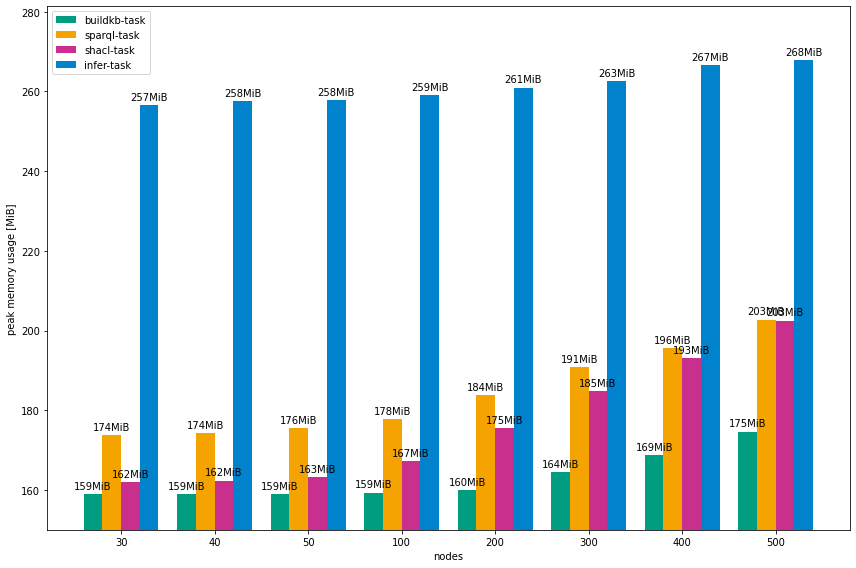

In [42]:
plotTaskMemoryComparison(lowStore_memory, ymin=150, ymax=None, fileBaseName="doublylinked_low_memory")

In [62]:
frame = pd.DataFrame(
    lowStore_memory['memory'].transform(lambda x: pd.Series(map(lambda v: v / (1024*1024), x.values()))),
)
frame.columns = columns=lowStore_memory['memory'].iloc[0].keys()
frame['infer'] / frame['buildkb']

30     1.615414
40     1.621176
50     1.621874
100    1.626197
200    1.631775
300    1.597391
400    1.579686
500    1.534302
dtype: float64

# High Store

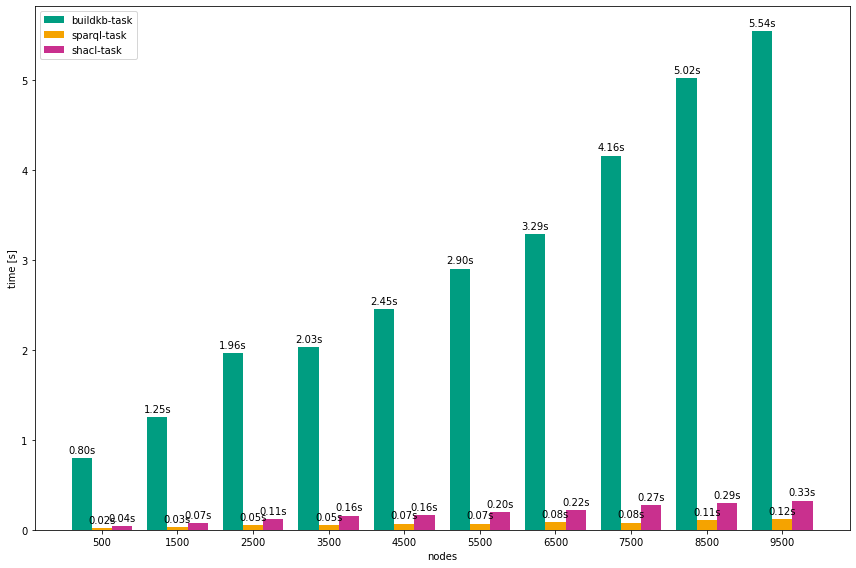

In [12]:
plotTaskTimeComparison(highStore_times, ymin=None, ymax=None, fileBaseName="doublylinked_high_times")

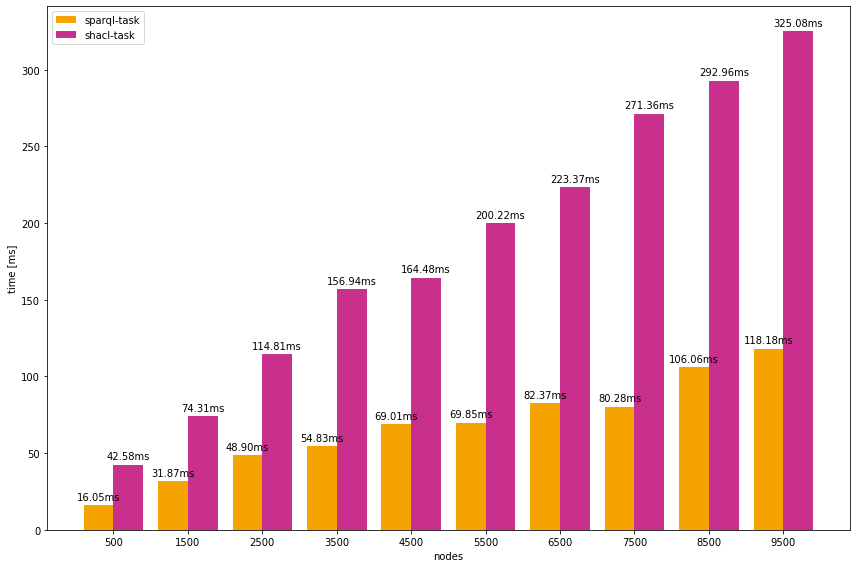

In [64]:
frame = highStore_times.copy()
frame['times'] = frame['times'].apply(lambda x: {k: x[k] for k in x if k != 'buildkb'})
plotTaskTimeComparison(frame, ymin=None, ymax=None, fileBaseName="doublylinked_high_times_detail", showMilliseconds=True)

array([0.51099471])

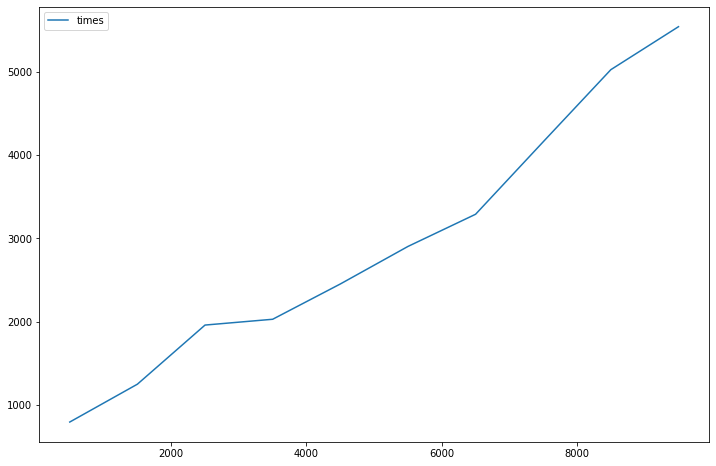

In [78]:
frame = pd.DataFrame(highStore_times['times'].apply(lambda x: x['buildkb'].total_seconds()*1000))
frame.plot()

from sklearn.linear_model import LinearRegression

frame.reset_index(inplace=True)
X = frame['index'].values.reshape(-1, 1)
Y = frame['times']

model = LinearRegression()
model.fit(X, Y)

model.coef_

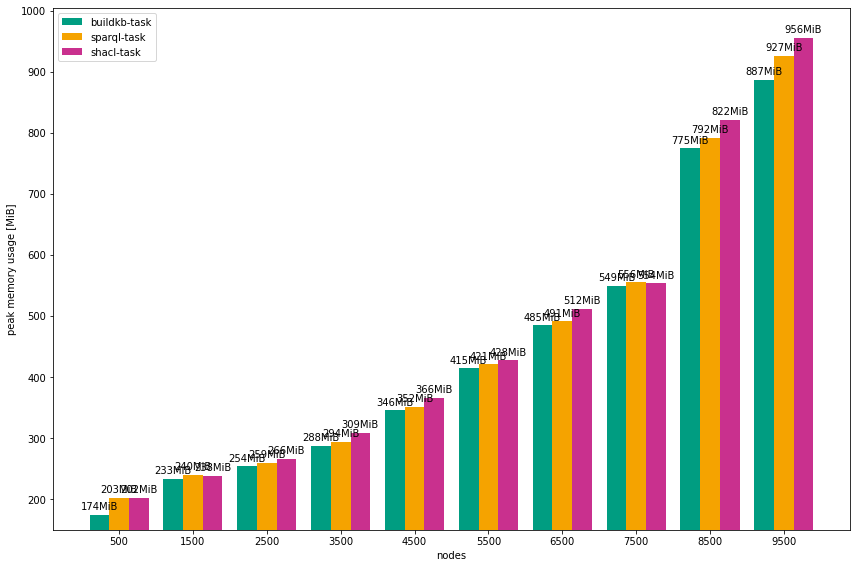

In [43]:
plotTaskMemoryComparison(highStore_memory, ymin=150, ymax=None, fileBaseName="doublylinked_high_memory")